# 3. Topic Modeling
In this notebook we will perform the initial topic modeling of the COVID and Agriculture datasets for the publications track of Hercules project. This phase will consist on the preprocessing of each dataset and the training of several topic models to infer the topics of each corpus.

## Setup

In [1]:
%run __init__.py

INFO:root:Starting logger


In [2]:
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/home/alejandro/.envs/edma/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Common functions

Before we start working with our first dataset, we are going a common set of functionality that will be used in both datasets. First of all, we will define a function to print a word cloud based on the given text:

In [3]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt


def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


We also will implement a custom class to perform the preprocessing of texts before they are used by the topic extraction models. This preprocessing will consist of the tokenization of each text, stop word removal and lemmatization. The [Spacy](https://spacy.io) library will be used for this task. Our TextPreprocessor class will allow the use of a custom Spacy model for each different dataset, as we will see later:

In [4]:
from herc_common.text import TextPreprocessor

The following function will be used to show the top terms of each topic extracted by a given model:

In [5]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


This next set of functions will be use to evaluate our topic extraction models after they have been trained. In the first cell we are making use of the [tmtoolkit](https://tmtoolkit.readthedocs.io/en/latest/) library to obtain the topic coherence of a given model. Specifically, we will be using the _u\_mass_ measure.

The second cell consists of a list of functions to try out several combinations of topics for each given model, and return the model with the best topic coherence amongst them.

In [6]:
import numpy as np

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim


def base_scoring_function(vectorizer, texts, model, X, top_n=10):
    return metric_coherence_gensim(measure='u_mass', dtm=X, 
                                   topic_word_distrib=model.components_,
                                   vocab=np.array([x for x in vectorizer.vocabulary_.keys()]), 
                                   texts=texts, return_mean=True)

In [7]:
MIN_TOPICS = 7
MAX_TOPICS = 30

def try_topics(model_cls, X, scoring_func, **kwargs):
    res = {}
    for num_topics in range(MIN_TOPICS, MAX_TOPICS):
        model = model_cls(n_components=num_topics, random_state=RANDOM_SEED, **kwargs)
        model.fit(X)
        score = scoring_func(model, X)
        res[model] = score
    return res

def print_results_info(model_results):
    best_model = get_best_model(model_results)
    print(f"Best model parameters: {best_model.get_params()}")
    print(f"Topic coherence: {model_results[best_model]}")

def get_best_model(model_results):
    return max(model_results, key=model_results.get)


Finally, we will define a final function to serialize our pipelines so we can load them later on in the following notebooks to obtain the topics of a given piece of text:

In [8]:
from herc_common.utils import save_object

Now that we have defined our common set of functions, we can start working on each dataset.

## Agriculture

### Loading the dataframe

In [10]:
DF_FILE_PATH = os.path.join(NOTEBOOK_2_RESULTS_DIR, 'protocols_dataframe.pkl')

df = pd.read_pickle(DF_FILE_PATH)

### Preprocessing text

In [11]:
protocols = df['full_procedure_cleaned'].values

In [12]:
import en_core_web_sm
import en_core_web_md

import en_core_sci_lg

custom_stop_words = {"introduction", "fig", "figure", "figures" "figs"}

preprocessor = TextPreprocessor(en_core_web_md, custom_stop_words)
preprocessed_texts = preprocessor.fit_transform(protocols)

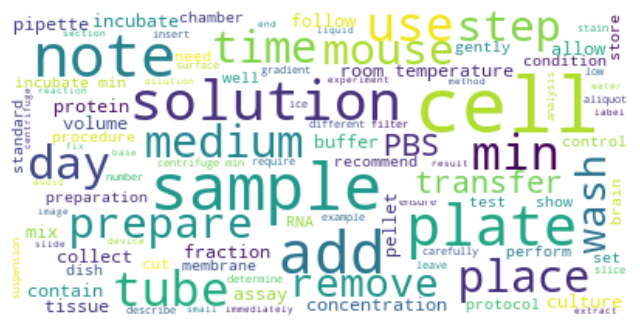

In [13]:
complete_text = ' '.join([' '.join(token) for token in preprocessed_texts])

plot_word_cloud(complete_text)

### LDA

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc


tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tf = tf_vectorizer.fit_transform(preprocessed_texts)

In [15]:
from functools import partial

from sklearn.decomposition import LatentDirichletAllocation


lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tf_vectorizer,
                                        texts=preprocessed_texts, model=clf, X=X)


lda_results = try_topics(LatentDirichletAllocation, dtm_tf, lda_scoring_func)#, max_iter=100)
lda_results

NameError: name 'RANDOM_SEED' is not defined

In [ ]:
print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

Visualization. Do this with the best model obtained before.

In [ ]:
best_lda_model = LatentDirichletAllocation(n_components=9, random_state=RANDOM_SEED)
best_lda_model.fit(dtm_tf)

In [ ]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 10)

In [ ]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tf, tf_vectorizer, mds='tsne')

In [ ]:
from sklearn.pipeline import Pipeline

lda_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lda_model)])

lda_protocols_pipe_filename = "protocols_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lda_protocols_pipe_filename))

In [ ]:
dtm_tf_filename = "protocols_dtm_tf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_3_RESULTS_DIR, dtm_tf_filename))

#### LDA with bigrams

In [ ]:
bigram_tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
bigram_dtm_tf = bigram_tf_vectorizer.fit_transform(preprocessed_texts)


bigram_lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=bigram_tf_vectorizer,
                                                               texts=preprocessed_texts, model=clf, X=X)


bigram_lda_results = try_topics(LatentDirichletAllocation, bigram_dtm_tf, bigram_lda_scoring_func)
bigram_lda_results

In [ ]:
# best_bigram_lda_model = get_best_model(bigram_lda_results)
best_bigram_lda_model = LatentDirichletAllocation(n_components=12)
best_bigram_lda_model.fit_transform(bigram_dtm_tf)

pyLDAvis.sklearn.prepare(best_bigram_lda_model, bigram_dtm_tf, bigram_tf_vectorizer, mds='tsne')

In [ ]:
bigram_lda_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                                ('vectorizer', bigram_tf_vectorizer),
                                ('model', best_bigram_lda_model)])

lda_bigram_agriculture_pipe_filename = "agriculture_bigram_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lda_bigram_agriculture_pipe_filename))

### Latent Semantic Analysis (LSA)

In [ ]:
from sklearn.decomposition import TruncatedSVD

lsa_scoring_func = lda_scoring_func

lsa_results = try_topics(TruncatedSVD, dtm_tf, lsa_scoring_func)
lsa_results

In [ ]:
print_results_info(lsa_results)
best_lsa_model = get_best_model(lsa_results)

In [ ]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lsa_model, tf_feature_names, 10)

In [ ]:
from sklearn.decomposition import TruncatedSVD

lsa_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lsa_model)])

lsa_agriculture_pipe_filename = "agriculture_lsa_model.pkl"
save_object(lsa_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lsa_agriculture_pipe_filename))

### NMF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [ ]:
from sklearn.decomposition import NMF

nmf_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tfidf_vectorizer,
                                                        texts=preprocessed_texts, model=clf, X=X)

nmf_results = try_topics(NMF, dtm_tfidf, nmf_scoring_func, max_iter=300)
nmf_results

In [ ]:
print_results_info(nmf_results)
best_nmf_model_2 = get_best_model(nmf_results)

In [ ]:
best_nmf_model = NMF(n_components=29, max_iter=400, random_state=RANDOM_SEED)
best_nmf_model.fit(dtm_tfidf)

In [ ]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(best_nmf_model, tfidf_feature_names, 10)

In [ ]:
from sklearn.pipeline import Pipeline

nmf_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tfidf_vectorizer),
                         ('model', best_nmf_model)])

nmf_agriculture_pipe_filename = "agriculture_nmf_model.pkl"
save_object(nmf_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, nmf_agriculture_pipe_filename))

In [ ]:
dtm_tfidf_filename = "agriculture_dtm_tfidf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_3_RESULTS_DIR, dtm_tfidf_filename))